# I. Data preparation

Loading data from source

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import tensorflow.keras.layers as tfl
import os
import pickle

In [2]:
from zipfile import ZipFile

# zip_dir = 'data/emotion_data.zip'
# extraction_dir = ""

# with ZipFile(zip_dir, 'r') as zip_object:
#     zip_object.extractall(path=extraction_dir)

# print(f"All files extracted from '{zip_dir}' to '{extraction_dir}'.")

data_dir = pathlib.Path("emotion_data/")

Viewing training data

In [3]:
num_train_images = len(list(data_dir.glob("train/*/*")))
print("Images:", num_train_images)
print("Classes:", list(data_dir.glob("train/*")))

Images: 28709
Classes: [WindowsPath('emotion_data/train/angry'), WindowsPath('emotion_data/train/disgust'), WindowsPath('emotion_data/train/fear'), WindowsPath('emotion_data/train/happy'), WindowsPath('emotion_data/train/neutral'), WindowsPath('emotion_data/train/sad'), WindowsPath('emotion_data/train/surprise')]


Viewing the images

emotion_data\train\angry


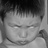

In [4]:
path = list(data_dir.glob("train/*"))[0]
print(str(path))
PIL.Image.open(str(list(path.glob("*"))[0]))

emotion_data\train\disgust


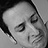

In [5]:
path = list(data_dir.glob("train/*"))[1]
print(str(path))
PIL.Image.open(str(list(path.glob("*"))[0]))

Loading the dataset

In [6]:
train_dir = pathlib.Path("emotion_data/train")

batch_size = 64
# img_height = 180
# img_width = 180
val_split = 0.2

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=val_split,
    subset="both",
    seed=91,
    image_size=(48,48),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=True
)
# train_ds = train_ds.shuffle(buffer_size=len(list(train_ds.as_numpy_iterator())))
# val_ds = val_ds.shuffle(buffer_size=len(list(val_ds.as_numpy_iterator())))

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Using 5741 files for validation.


Viewing some batches

In [7]:
b = 3
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    print("Max:", np.max(image_batch.numpy()))
    print("Min:", np.min(image_batch.numpy()))
    print("Labels:", np.unique(labels_batch.numpy()))
    print()
    b-=1
    if b<=0:
        break

(64, 48, 48, 1)
(64,)
Max: 255.0
Min: 0.0
Labels: [0 2 3 4 5 6]

(64, 48, 48, 1)
(64,)
Max: 255.0
Min: 0.0
Labels: [0 1 2 3 4 5 6]

(64, 48, 48, 1)
(64,)
Max: 255.0
Min: 0.0
Labels: [0 2 3 4 5 6]



## Training preparation

In [8]:
class_names = train_ds.class_names
image_shape = None
labels_shape = None
num_classes = len(class_names)

for image_batch, labels_batch in train_ds:
    image_shape = image_batch.shape[1:]
    labels_shape = labels_batch.numpy().reshape(-1, 1).shape[1:]
    break

print(class_names, image_shape, labels_shape)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'] (48, 48, 1) (1,)


Dataset configuration

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

subset_reduction_factor_train = 0.2
subset_reduction_factor_val = 0.2
num_batches = num_train_images//batch_size

train_subset_size = int(num_batches*(1-val_split)*subset_reduction_factor_train)
val_subset_size = int(num_batches*val_split*subset_reduction_factor_val)

used_train_ds = train_ds.cache().take(train_subset_size).prefetch(buffer_size=AUTOTUNE)
used_val_ds = val_ds.cache().take(val_subset_size).prefetch(buffer_size=AUTOTUNE)

train_subset_size, val_subset_size

(71, 17)

Viewing training and validation data to ensure similar representations

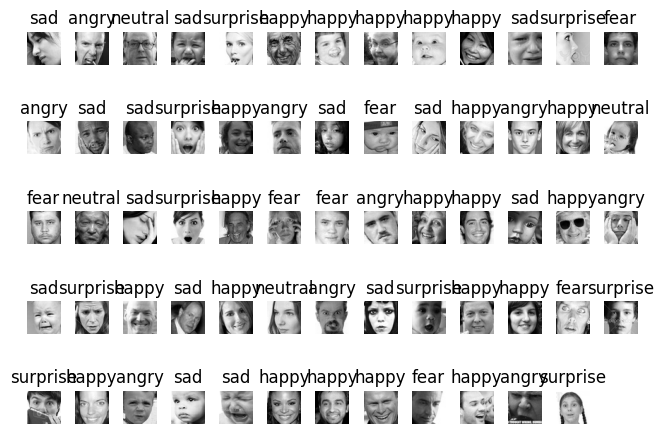

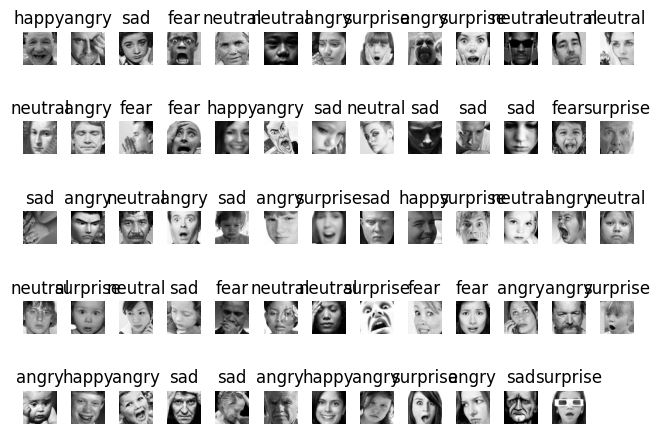

In [10]:
def view_batch(ds, batch_num):
    c = 0
    for image_batch, labels_batch in ds:
        if batch_num != c:
            c+=1
            continue
        # print(image_batch.shape[0], int(np.ceil(image_batch.shape[0]/5)))
        for index, image in enumerate(image_batch):
            label = labels_batch[index]
            ax = plt.subplot(5, int(np.ceil(image_batch.shape[0]/5)), index+1)
            ax.imshow(image.numpy().astype("uint8"), cmap="gray")
            ax.axis("off")
            ax.set_title(class_names[label.numpy()])
        break
    plt.tight_layout()
    plt.show()

def view_batch_shape(ds):
    for i, j in ds:
        print(i.shape, j.shape)
        break

view_batch(used_train_ds, 1)
view_batch(used_val_ds, 1)

# 2. Training

## Utilities

### Save/load utilities

Every time a distinct model is trained and/or used for observations, call `set_save_paths(model_name: str)`. Use the paths `checkpoint_path` and `base_path`, as well as the subroutines below, accordingly.

Information that can be saved and loaded are the training history and the parameters of a model.

By default, models load pretrained weights. Cells containing `model.fit()` can be optionally run once or multiple times by changing the cell format from raw to Python.

To train a fresh model, delete/rename the `training` folder (or its specific subfolders)

In [13]:
base_path:str = None
checkpoint_path:str = None
current_model_name:str = None

In [14]:
def create_path(filepath, isfile=True):
    path = pathlib.Path(filepath)
    if isfile:
        path.parent.mkdir(parents=True, exist_ok=True)
        path.touch(exist_ok=True)
    else:
        path.mkdir(parents=True, exist_ok=True)

def set_save_paths(model_name:tf.keras.Model):
    global checkpoint_path
    global base_path
    global current_model_name
    current_model_name = model_name
    base_path = f"training/{model_name}"
    checkpoint_path = f"{base_path}/parameters.weights.h5"
    print("Save path now belongs to", current_model_name)

def load_parameters(model, custom_model_name=None):
    global checkpoint_path
    global base_path
    global current_model_name

    used_model_name = custom_model_name if custom_model_name != None else current_model_name
    used_checkpoint_path = f"training/{used_model_name}/parameters.weights.h5"

    print("Loading parameters of", used_model_name, f"({'Custom' if custom_model_name != None else 'Default'})")

    if not os.path.isfile(used_checkpoint_path):
        print("No parameters found, no parameters loaded from", used_model_name)
        return

    model.load_weights(used_checkpoint_path, skip_mismatch=True)

def save_object(object, name="history"):
    global checkpoint_path
    global base_path
    global current_model_name

    path = f"{base_path}/{name}"

    create_path(path, isfile=False)

    all_items = os.listdir(path)
    files_only = [os.path.join(path, item) for item in all_items]
    files_only = [item for item in files_only if os.path.isfile(item)]
    
    filepath = f"{path}/{len(files_only)}.pickle"
    create_path(filepath)
    
    print(f"Saving {name} of", current_model_name)
    with open(filepath, 'wb') as f:
        pickle.dump(object.history if name=="history" else object, f)

def load_object(name="history"):
    global checkpoint_path
    global base_path
    global current_model_name
    
    path = f"{base_path}//{name}"

    print(f"Loading {name} of", current_model_name)
    histories = []
    for i in os.listdir(path):
        path = os.path.join(path, i)
        if not os.path.isfile(path):
            continue
        with open(path, 'rb') as f:
            histories.append(pickle.load(f))
        
    return histories

def plot_object(chosen_attributes, ylim1=0, ylim2=1, name="history"):
    objects = load_object(name)
    for i in chosen_attributes:
        attribute_list = [item for cur_object in objects for item in cur_object[i]]
        plt.plot(np.arange(len(attribute_list)), attribute_list, label=i)
    plt.legend()
    plt.ylim(ylim1, ylim2)
    plt.title(f"{name} of {current_model_name}")
    plt.show()

## Model approaches

### Standard approach

In [17]:
set_save_paths("standard_model")

model = tf.keras.models.Sequential([
    tfl.Rescaling(1/255, input_shape=image_shape),
    tfl.Conv2D(16, 3, padding='same', activation='relu', name="conv1"),
    tfl.MaxPooling2D(2),
    tfl.Conv2D(32, 3, padding='same', activation='relu', name="conv2"),
    tfl.MaxPooling2D(2),
    tfl.Conv2D(64, 3, padding='same', activation='relu', name="conv3"),
    tfl.AveragePooling2D(3),
    tfl.Flatten(),
    tfl.Dense(128, activation='relu', name="dense1"),
    tfl.Dense(num_classes, name="dense2")
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

load_parameters(model)
model.summary()

Save path now belongs to standard_model
Loading parameters of standard_model (Default)
No parameters found, no parameters loaded from standard_model


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 4, 4, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,399 (607.03 KB)

 Trainable params: 155,399 (607.03 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
load_parameters(model)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)

history = model.fit(
    used_train_ds,
    validation_data=used_val_ds,
    epochs=20,
    callbacks=[cp_callback]
)

save_object(history)

Loading parameters of standard_model (Default)
No parameters found, no parameters loaded from standard_model
Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.2334 - loss: 1.8582 - val_accuracy: 0.2675 - val_loss: 1.7955
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.2383 - loss: 1.8152 - val_accuracy: 0.2675 - val_loss: 1.7589
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.2923 - loss: 1.7551 - val_accuracy: 0.3235 - val_loss: 1.6931
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3314 - loss: 1.6895 - val_accuracy: 0.3787 - val_loss: 1.6035
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3722 - loss: 1.6274 - val_accuracy: 0.3842 - val_loss: 1.5676
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3854 - loss: 1.5838 - val_accuracy: 0.4090 - val_loss: 1.5357
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4122 - loss: 1.5589 - val_accuracy: 0.4154 - val_loss: 1.5182
Ep

Loading history of standard_model


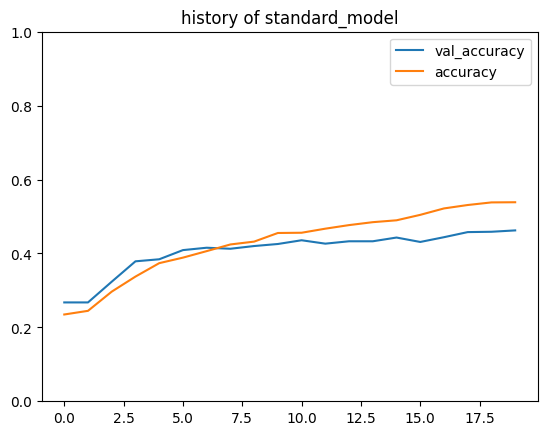

In [19]:
plot_object(["val_accuracy", "accuracy"])

Problems include slow learning and overfitting. The next approach addresses the latter.

### Augmentation utility

In [15]:
augmentation = tf.keras.models.Sequential([
    tfl.RandomFlip("horizontal", input_shape=image_shape),
    tfl.RandomRotation(0.05),
    tfl.RandomZoom(height_factor=(-0.1, 0), fill_mode="constant", fill_value=0),
])

c:\Users\slotl\Documents\GitHub\ml-with-images\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Data augmentation

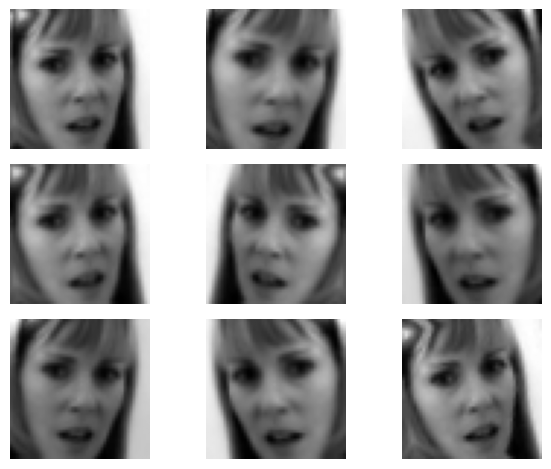

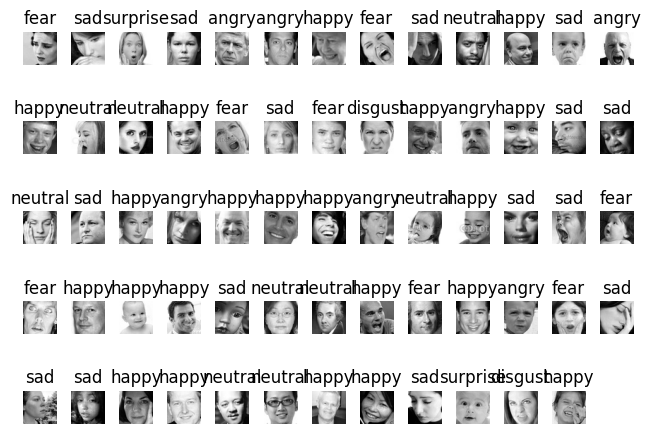

In [16]:
# Taking one batch, applying the augmentation on that same batch multiple times, and then showing variations of a specific picture in that batch
image_in_batch = 1
for images, _ in used_train_ds:
    for i in range(9):
        augmented_images = augmentation(images) # augmentation alters image randomly every time
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[image_in_batch].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
    break
plt.tight_layout()
plt.show()
view_batch(used_train_ds, 0)

Seems like the augmentation is pretty reasonable

In [18]:
set_save_paths("augmentation_model")

model = tf.keras.models.Sequential([
    augmentation,
    tfl.Rescaling(1/255, input_shape=image_shape),
    tfl.SeparableConv2D(16, 3, padding='same', activation='relu', name="conv1", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform()),
    tfl.MaxPooling2D(2),
    tfl.SeparableConv2D(32, 3, padding='same', activation='relu', name="conv2", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform()),
    tfl.MaxPooling2D(2),
    tfl.SeparableConv2D(64, 3, padding='same', activation='relu', name="conv3", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform()),
    tfl.MaxPooling2D(2),
    tfl.SeparableConv2D(64, 3, padding='same', activation='relu', name="conv4", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform()),
    tfl.AveragePooling2D(3),
    tfl.Flatten(),
    tfl.Dense(128, activation='relu', name="dense1"),
    tfl.Dense(num_classes, name="dense2")
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

load_parameters(model)
model.summary()

Save path now belongs to augmentation_model


c:\Users\slotl\Documents\GitHub\ml-with-images\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Loading parameters of augmentation_model (Default)
No parameters found, no parameters loaded from augmentation_model


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (SeparableConv2D)         │ (None, 48, 48, 16)     │            41 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (SeparableConv2D)         │ (None, 24, 24, 32)     │           688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (SeparableConv2D)         │ (None, 12, 12, 64)     │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (SeparableConv2D)         │ (None, 6, 6, 64)       │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 2, 2, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,664 (162.75 KB)

 Trainable params: 41,664 (162.75 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
load_parameters(model)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',  # Metric to monitor (e.g., validation loss)
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best monitored value
)

history = model.fit(
    used_train_ds,
    validation_data=used_val_ds,
    epochs=20,
    callbacks=[cp_callback, es_callback]
)

save_object(history)

Loading parameters of augmentation_model (Default)
Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.3026 - loss: 1.7209 - val_accuracy: 0.2960 - val_loss: 1.6969
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.3047 - loss: 1.7116 - val_accuracy: 0.3033 - val_loss: 1.6929
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.3003 - loss: 1.7205 - val_accuracy: 0.3042 - val_loss: 1.6880
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.3056 - loss: 1.7137 - val_accuracy: 0.3171 - val_loss: 1.6801
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.3230 - loss: 1.6923 - val_accuracy: 0.3244 - val_loss: 1.6908
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.3253 - loss: 1.7070 - val_accuracy: 0.3070 - val_loss: 1.6800
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.3181 - loss: 1.6988 - val_accuracy: 0.3153 - val_loss: 1.6720
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accurac

Loading history of augmentation_model


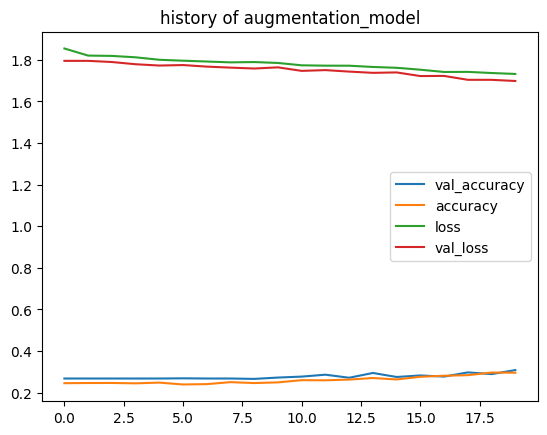

In [23]:
plot_object(["val_accuracy", "accuracy", "loss", "val_loss"], None, None)

Overfitting is reduced but learning is really slow